# MATH 42
***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
college_df = pd.read_csv('https://raw.githubusercontent.com/jaidenha/math42//main/nba_players_college_stats.csv')
nba_df = pd.read_csv('https://raw.githubusercontent.com/jaidenha/math42//main/nbastats.csv', encoding = 'latin-1')

# PER Function

In [ ]:
'''
ORIGINAL PER Equation

uPER = (1 / MP) *
     [ 3P
     + (2/3) * AST
     + (2 - factor * (team_AST / team_FG)) * FG
     + (FT *0.5 * (1 + (1 - (team_AST / team_FG)) + (2/3) * (team_AST / team_FG)))
     - VOP * TOV
     - VOP * DRB% * (FGA - FG)
     - VOP * 0.44 * (0.44 + (0.56 * DRB%)) * (FTA - FT)
     + VOP * (1 - DRB%) * (TRB - ORB)
     + VOP * DRB% * ORB
     + VOP * STL
     + VOP * DRB% * BLK
     - PF * ((lg_FT / lg_PF) - 0.44 * (lg_FTA / lg_PF) * VOP) ]

Glossary:
MP - Minutes played
3P - 3-point field goals
AST - Assist
FG - Team Field Goals (includes both 2-point field goals and 3-point field goals)
FT - Free Throws
TOV - Turnovers
DRB% - Defensive Rebound Percentage (DRB% = (lg_TRB - lg_ORB) / lg_TRB)
FGA - Field Goal Attempts (includes both 2-point field goal attempts and 3-point field goal attempts)
FTA - Free Throw Attempts
TRB - Total Rebounds
ORB - Offensive Rebounds
STL - Steals
BLK - Blocks
lg - league

VOP = lg_PTS / (lg_FGA - lg_ORB + lg_TOV + 0.44 * lg_FTA)
factor = (2 / 3) - (0.5 * (lg_AST / lg_FG)) / (2 * (lg_FG / lg_FT))
'''

'''
ALTERNATIVE VERSION OF PER

PER = [ FGM x 85.910
+ Steals x 53.897
+ 3PTM x 51.757
+ FTM x 46.845
+ Blocks x 39.190
+ Offensive_Reb x 39.190
+ Assists x 34.677
+ Defensive_Reb x 14.707
- Foul x 17.174
- FT_Miss x 20.091
- FG_Miss x 39.190
- TO x 53.897 ]
x (1 / Minutes).

Extended Glossary:
FGM = Field Goals Made
PTM = Points Made

'''

def PER(df):
  return ((df['FG'] * 85.910
          + df['STL'] * 53.897
          + df['FG3'] * 51.757
          + df['FT'] * 46.845
          + df['BLK'] * 39.190
          + df['ORB'] * 39.190
          + df['AST'] * 34.677
          + df['DRB'] * 14.707
          - df['PF'] * 17.174
          - df['FTA'] * 20.091
          - df['FGA'] * 39.190
          - df['TOV'] * 53.897)
          * (1 / df['MP']))

# College Stats Data Cleanup

In [ ]:
'''
Dealing w/ missing data: (based on basketballreference.com)
- Zero out three-point field goals, turnovers, blocked shots, and steals.
- Set the league value of possession (VOP) equal to 1.
- Set the defensive rebound percentage (DRB%) equal to 0.7.
- Set player offensive rebounds (ORB) equal to 0.3 * TRB.

Data Glossary:
G - Games
MP - Minutes Played
FG - Field Goals
FGA - Field Goal Attempts
FG3 - 3-points Field Goal
FG3A - 3-points Field Goal Attempts
FT - Free Throws
FTA - Free Throw Attempts
ORB - Offensive Rebounds
TRB - Total Rebounds
AST - Assists
STL - Steal
BLK - Block
TOV - Turnovers
PF - Personal Fouls
PTS - Points
PCT - Percentage
'''

# Read data
college_df = pd.read_csv('https://raw.githubusercontent.com/jaidenha/math42/main/nba_players_college_stats.csv')

# Rename columns to match the PER function
college_df = college_df.rename(str.upper, axis='columns')

# Clean up
college_df = college_df.drop(['PLAYER_HTML'], axis=1)
college_df.drop_duplicates(subset='NAME', keep='last', inplace=True) # Get only latest data
college_df['SEASON'] = college_df['SEASON'].replace(r'[-|&0-9]{3}$', '', regex=True)
college_df['SEASON'] = college_df['SEASON'].astype('int64')

# Handle missing data
college_df.dropna(subset='MP', inplace=True) # Avoid infinite, plus it doesnt make sense to include 0 minutes played (never been played)
college_df.drop(college_df[college_df['MP'] == 0].index, inplace=True) # Same thing here

# Calculate DRB (Defensive Rebounds) from assumption
college_df['ORB'] = college_df['ORB'].fillna(0.3 * college_df['TRB']) # Only fill NaNs
college_df['DRB'] = college_df['TRB'] - college_df['ORB'] # Defensive rebounds = Total rebounds - Offensive rebounds

college_df = college_df.fillna(0) # Fill everything else with 0 according to assumption
college_df.reset_index(drop=True, inplace=True) # Tidy up

# Calculate PER
college_df['PER'] = PER(college_df)
college_df.sort_values(by='PER', ascending=False)

,NAME,AGE,COLLEGE_ID,G,MP,FG,FGA,FG3,FG3A,FT,...,FG_PCT,FG3_PCT,FT_PCT,MP_PER_G,PTS_PER_G,TRB_PER_G,AST_PER_G,SEASON,DRB,PER
2100,James Wiseman,18,MEMPHIS,3.0,69.0,20.0,26.0,0.0,1.0,19.0,...,0.769,0.000,0.704,23.0,19.7,10.7,0.3,2019,19.0,29.412812
1609,Bill Cartwright,21,SANFRAN,29.0,1020.0,268.0,443.0,0.0,0.0,174.0,...,0.605,0.000,0.734,35.2,24.5,15.7,1.9,1978,318.5,22.698922
2121,Zion Williamson,18,DUKE,33.0,990.0,296.0,435.0,24.0,71.0,130.0,...,0.680,0.338,0.640,30.0,22.6,8.9,2.1,2018,177.0,22.076436
739,Larry Johnson,21,UNLV,35.0,1113.0,308.0,465.0,17.0,48.0,162.0,...,0.662,0.354,0.818,31.8,22.7,10.9,3.0,1990,266.0,22.059575
648,Bo Kimble,23,LOYOLAMARY,32.0,1053.0,404.0,763.0,92.0,200.0,231.0,...,0.529,0.460,0.862,32.9,35.3,7.7,1.9,1989,148.0,21.991034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,Dennis Johnson,21,PEPPERDINE,27.0,930.0,181.0,378.0,0.0,0.0,63.0,...,0.479,0.000,0.563,34.4,15.7,5.8,2.4,1975,109.2,1.109335
2369,Keith Tower,21,NOTREDAME,31.0,774.0,55.0,139.0,0.0,2.0,24.0,...,0.396,0.000,0.545,25.0,4.3,5.3,1.4,1991,115.5,1.095024
2443,Mike Taylor,21,IOWAST,31.0,1086.0,165.0,439.0,77.0,214.0,88.0,...,0.376,0.360,0.682,35.0,16.0,4.1,4.5,2006,104.0,1.062542
1604,Bobby Cattage,22,AUBURN,27.0,424.0,52.0,129.0,0.0,0.0,24.0,...,0.403,0.000,0.558,15.7,4.7,3.4,0.3,1980,65.1,0.618381


<Axes: xlabel='PER', ylabel='Count'>

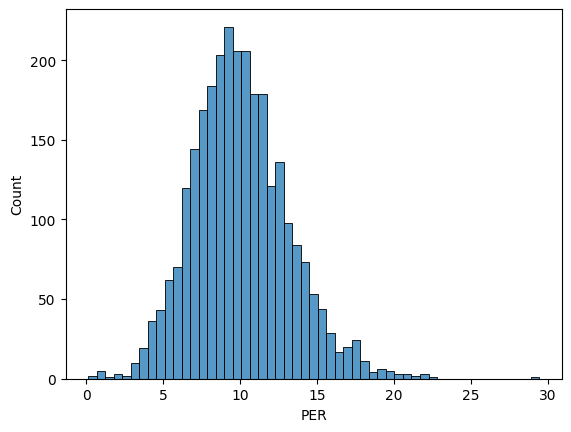

In [ ]:
# college stats histplot
sns.histplot(data = college_df['PER'])

<Axes: xlabel='PER'>

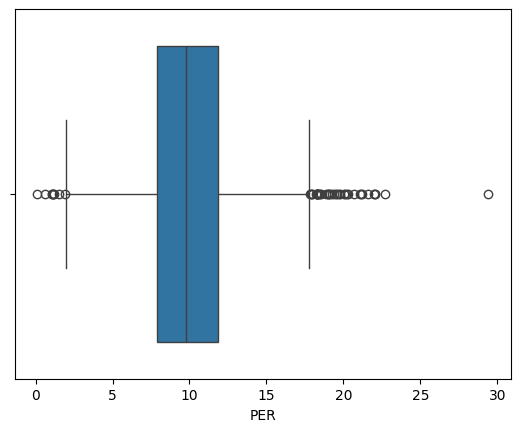

In [ ]:
# college stats boxplot
sns.boxplot(x = college_df['PER'])

In [ ]:
# analyze data with specific stats
q1 = college_df['PER'].quantile(0.25)
q3 = college_df['PER'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("Q1: {}".format(q1))
print("Q3: {}".format(q3))
print("IQR: {}".format(iqr))
print("Lower Bound: {}".format(lower_bound))
print("Upper Bound: {}".format(upper_bound))

Q1: 7.905916675025507
Q3: 11.850997509415423
IQR: 3.945080834389916
Lower Bound: 1.9882954234406327
Upper Bound: 17.768618761000297


# *NBA Stats Data Cleanup*

In [ ]:
'''
Dealing w/ missing data: (based on basketballreference.com)
- Zero out three-point field goals, turnovers, blocked shots, and steals.
- Set the league value of possession (VOP) equal to 1.
- Set the defensive rebound percentage (DRB%) equal to 0.7.
- Set player offensive rebounds (ORB) equal to 0.3 * TRB.
'''

# Read data
nba_df = pd.read_csv('https://raw.githubusercontent.com/jaidenha/math42/main/nbastats.csv', encoding = 'latin-1')

# Rename columns to match the PER function
nba_df = nba_df.rename(str.upper, axis='columns')
nba_df = nba_df.drop([nba_df.columns[0], 'BLANL', 'BLANK2'], axis=1)
nba_df['PLAYER'] = nba_df['PLAYER'].replace(r'\*$', '', regex=True)

# Some cleanup
nba_df.insert(len(nba_df.columns)-1, 'PER', nba_df.pop('PER'))
nba_df['YEAR'] = nba_df['YEAR'].astype('int64')
nba_df.head()

,YEAR,PLAYER,POS,AGE,TM,G,GS,MP,TS%,3PAR,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER
0,1981,Kareem Abdul-Jabbar,C,33.0,LAL,80.0,NaN,2976.0,0.616,0.001,...,197.0,624.0,821.0,272.0,59.0,228.0,249.0,244.0,2095.0,25.5
1,1981,Alvan Adams,C,26.0,PHO,75.0,NaN,2054.0,0.567,0.000,...,157.0,389.0,546.0,344.0,106.0,69.0,226.0,226.0,1115.0,20.3
2,1981,Tiny Archibald,PG,32.0,BOS,80.0,72.0,2820.0,0.582,0.012,...,36.0,140.0,176.0,618.0,75.0,18.0,265.0,201.0,1106.0,14.3
3,1981,James Bailey,PF,23.0,SEA,82.0,NaN,2539.0,0.546,0.002,...,192.0,415.0,607.0,98.0,74.0,143.0,219.0,332.0,1145.0,14.5
4,1981,Greg Ballard,SF,26.0,WSB,82.0,NaN,2610.0,0.500,0.027,...,167.0,413.0,580.0,195.0,118.0,39.0,117.0,194.0,1271.0,16.7


In [ ]:
# analyze nba data with specific stats
q1 = nba_df['PER'].quantile(0.25)
q3 = nba_df['PER'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("Q1: {}".format(q1))
print("Q3: {}".format(q3))
print("IQR: {}".format(iqr))
print("Lower Bound: {}".format(lower_bound))
print("Upper Bound: {}".format(upper_bound))

Q1: 12.4
Q3: 17.0
IQR: 4.6
Lower Bound: 5.500000000000001
Upper Bound: 23.9


In [ ]:
nba_df['PER'].isnull().sum()

0

In [ ]:
nba_df['PER'].mean()

14.955477543742338

# *Analyze Actual Career Stats For Probabilities*

Changes: Fixed data cleaning on -1 and 0 values. Changed timestep to 1 instead of 3

<!-- Possible change: change the timestep to 1? or stick with 3 -->

In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Decide thresholds

# good = 17.5+
# decent = 15 - 17.5
# mediocre = 12.5 - 15
# bad = 12.5-
# ool = out of the league

In [ ]:
'''
Using PER results, analyze actual careers of all the players in each state (bad to good) and decide on probabilities using that analysis
  Analyzing: (i = time jump = 3, cus avg time of player in NBA ~4 year)
  Take n players from each state
  Take year k in their college year and calculate the PER
  Take year k+i in their NBA year and calculate the PER (so every 5 year timestamp)
  From year k+i calculate the distribution in which state they stayed
  From the distribution simply divide by the samples to get the probability of the state moving (build the markov chain)
  Repeat (iii to v) for k+yi to get the probability (another markov chain from year k+i to year k+yii) (y=number of repetition)
'''

# College Data
college_df_per = college_df[['NAME', 'SEASON', 'PER']]

# NBA Data
nba_df_per = nba_df[['PLAYER', 'YEAR', 'PER']].rename(columns={'PLAYER': 'NAME', 'YEAR': 'SEASON'})

# Combined Data
combined_df = pd.concat([college_df_per, nba_df_per]) # Concat
combined_df = combined_df.sort_values(by=['NAME', 'SEASON']).reset_index(drop=True) # Sort
combined_df = combined_df[combined_df['NAME'].duplicated(keep=False)]
combined_df = combined_df.drop_duplicates(subset=['NAME','SEASON'])


time_step = 3 # Time step (years) (change it back to 3 years?)

# Filter data based on every timestep
timestep_df = pd.DataFrame()
for player in combined_df['NAME'].unique():
  df = combined_df[combined_df['NAME'] == player]
  filtered_df = pd.DataFrame(data={'NAME': player}, index=[0])

  # Take every i year from earliest season
  per_i = (df['SEASON'] - df['SEASON'].min()) # Take difference from the very first season
  df['PER_i'] = per_i # Assign new column
  filtered_df = df[(per_i % time_step) == 0].reset_index(drop=True) # Get every timestep
  filtered_df.drop('SEASON', axis=1, inplace=True) # Drop Season

  # Labeling
  filtered_df['PER_i'] = filtered_df['PER_i'].apply(lambda x: 'PER +{}'.format(x)) # Renaming for cols

  # Pivot the data so every PER becomes columns
  filtered_df = filtered_df.pivot(index=['NAME'], columns=['PER_i'], values='PER').reset_index()
  filtered_df = filtered_df.rename_axis(None, axis=1) # Remove index naming

  # Append player stats to the main dataframe
  timestep_df = pd.concat([timestep_df, filtered_df])

# Clean up
timestep_df = timestep_df.reset_index(drop=True)

# Reorder the columns
order = np.arange(0, (len(timestep_df.columns)-1)*time_step, time_step) # Create the order based on columns length and time step
format = lambda x: 'PER +{}'.format(x)
cols = np.array([format(val) for val in order]) # Reformat 'order'
cols = np.insert(cols, 0, 'NAME', axis=0) # Add 'NAME' column

timestep_df = timestep_df.reindex(columns=cols) # Reorder columns order

# Dealing with NaNs

# Set player as Out of The League when player haven't played in 2 consecutive timestep
n_cols_to_check = len(timestep_df.columns) # Get number of columns to check
for i in range(2, n_cols_to_check-2): # From PER +3, doesn't make sense to have them out of the league in the first place
  curr_col = timestep_df.iloc[:, i]
  next_col = timestep_df.iloc[:, i+1]
  next2_col = timestep_df.iloc[:, i+2]

  timestep_df.iloc[:, i] = curr_col.mask((curr_col.isna() & next_col.isna() & next2_col.isna()), -1) # Check if there is no data for 2 straight consecutive timestep

# If player is already assigned out of the league, keep them be.
for i in range(3, n_cols_to_check): # From PER +6
  curr_col = timestep_df.iloc[:, i]
  prev_col = timestep_df.iloc[:, i-1]
  timestep_df.iloc[:, i] = curr_col.mask(prev_col == -1, -1)

# Assume that if theres no data on the last season, the player is out of the league
timestep_df.iloc[:, -1] = timestep_df.iloc[:, -1].mask(timestep_df.iloc[:, -1].isna(), -1)

# # If player didn't play in current timestep and player is OOL at the next timestep, also consider OOL (Backward Direction)
# for i in range(n_cols_to_check-1, 2, -1): # From latest PER to PER +3
#   timestep_df.iloc[:, i-1] = timestep_df.iloc[:, i-1].mask((timestep_df.iloc[:, i] == -1) & (timestep_df.iloc[:, i-1].isna()), -1)

# Fill everything else with 0 and considering them as bad since everything else is already filtered
timestep_df.fillna(0, inplace=True)

# Check
timestep_df

,NAME,PER +0,PER +3,PER +6,PER +9,PER +12,PER +15,PER +18,PER +21,PER +24,PER +27,PER +30,PER +33,PER +36,PER +39
0,A.C. Green,11.403172,15.7,14.7,16.3,12.9,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,A.J. English,10.600000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,A.J. Price,6.936948,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,Aaron Brooks,8.984064,12.9,0.0,14.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,Aaron Gordon,8.798262,17.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,Yogi Ferrell,10.805395,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1470,Zach LaVine,6.141496,14.3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1471,Zach Randolph,13.811680,19.9,16.9,19.6,0.0,19.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1472,Zaza Pachulia,14.400000,0.0,12.4,14.0,16.1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# *Calculating Probabilities*

Changes: Instead of 5 iteration, calculated with all data available

In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
'''
Decided thresholds:
good = 17.5+
decent = 15 - 17.5
mediocre = 12.5 - 15
bad = 0 - 12.5
ool = -1

PER 0: College stats
PER 3: 3 years after college
PER 6: 6 years after college
.
.
PER i: i years after college
'''

n = len(timestep_df.columns)-1 # all available data
# n = 5 # n iteration

# Get players of players in each state in each timestep
df = np.empty((n, 5), dtype=object) # rows = n = num iteration, columns = states
for j in range(0, n): # n = num iteration
  per_i_df = timestep_df[f'PER +{time_step*j}']
  df[j, 0] = timestep_df[per_i_df == -1.0] # OOL
  df[j, 1] = timestep_df[(per_i_df >= 0) & (per_i_df < 12.5)] # BAD
  df[j, 2] = timestep_df[(per_i_df >= 12.5) & (per_i_df < 15)] # MEDIOCRE
  df[j, 3] = timestep_df[(per_i_df >= 15) & (per_i_df < 17.5)] # DECENT
  df[j, 4] = timestep_df[per_i_df >= 17.5] # GOOD

# Calculate probability for each timestep
probs = np.zeros((n-1, 5, 5), dtype='float64')

for j in range(0, n-1): # n = num iteration
  for k in range(0, 5): # k = selected state
    for h in range(0, 5): # h = for each states
      num_players_moved = df[j, k]['NAME'].isin(df[j+1, h]['NAME'].values).sum()
      probs[j, h, k] = np.round(num_players_moved/len(df[j, k]), 2)

      if(num_players_moved == 0): # if no more players are moving, set probability to 1 (only for OOL) others set to 0
        probs[j, h, k] = 1.0 if h == 0 else 0.0

# Set initial probability matrix for OOL to 0, except from OOL to OOL (ofc no one starts at out of the league)
for j in range(0, 5): #
  probs[0, j, 0] = 0.0
probs[0, 0, 0] = 1.0 # Set OOL -> OOL in initial probability matrix to 1

# Print probabilities for each timestep
curr = 0
for j in range(0, n-1):
  print('YEAR {} TO {}'.format(curr+1, j*time_step+time_step+1))
  print(probs[j])
  print()
  curr += time_step


YEAR 1 TO 4
[[1.   0.2  0.16 0.18 0.27]
 [0.   0.42 0.31 0.24 0.08]
 [0.   0.2  0.17 0.12 0.11]
 [0.   0.13 0.21 0.19 0.19]
 [0.   0.06 0.14 0.28 0.35]]

YEAR 4 TO 7
[[1.   0.23 0.34 0.22 0.14]
 [0.   0.36 0.19 0.1  0.07]
 [0.   0.23 0.17 0.15 0.1 ]
 [0.   0.11 0.2  0.24 0.15]
 [0.   0.06 0.11 0.28 0.54]]

YEAR 7 TO 10
[[1.   0.39 0.39 0.28 0.23]
 [0.   0.29 0.25 0.18 0.05]
 [0.   0.18 0.18 0.23 0.1 ]
 [0.   0.09 0.15 0.21 0.15]
 [0.   0.05 0.03 0.09 0.47]]

YEAR 10 TO 13
[[1.   0.65 0.58 0.49 0.23]
 [0.   0.18 0.22 0.15 0.1 ]
 [0.   0.11 0.13 0.19 0.07]
 [0.   0.06 0.06 0.13 0.23]
 [0.   0.01 0.01 0.03 0.37]]

YEAR 13 TO 16
[[1.   0.79 0.74 0.58 0.33]
 [0.   0.08 0.14 0.1  0.  ]
 [0.   0.09 0.07 0.19 0.12]
 [0.   0.01 0.04 0.09 0.19]
 [0.   0.03 0.01 0.04 0.35]]

YEAR 16 TO 19
[[1.   0.96 0.88 0.67 0.63]
 [0.   0.04 0.09 0.1  0.  ]
 [0.   0.   0.   0.19 0.07]
 [0.   0.   0.03 0.05 0.07]
 [0.   0.   0.   0.   0.22]]

YEAR 19 TO 22
[[1.   1.   1.   1.   0.83]
 [0.   0.   0.   0.   0.  ]

# *State Diagram*

Tryna make a state diagram for each transition matrices, but not sure if it looks good or not

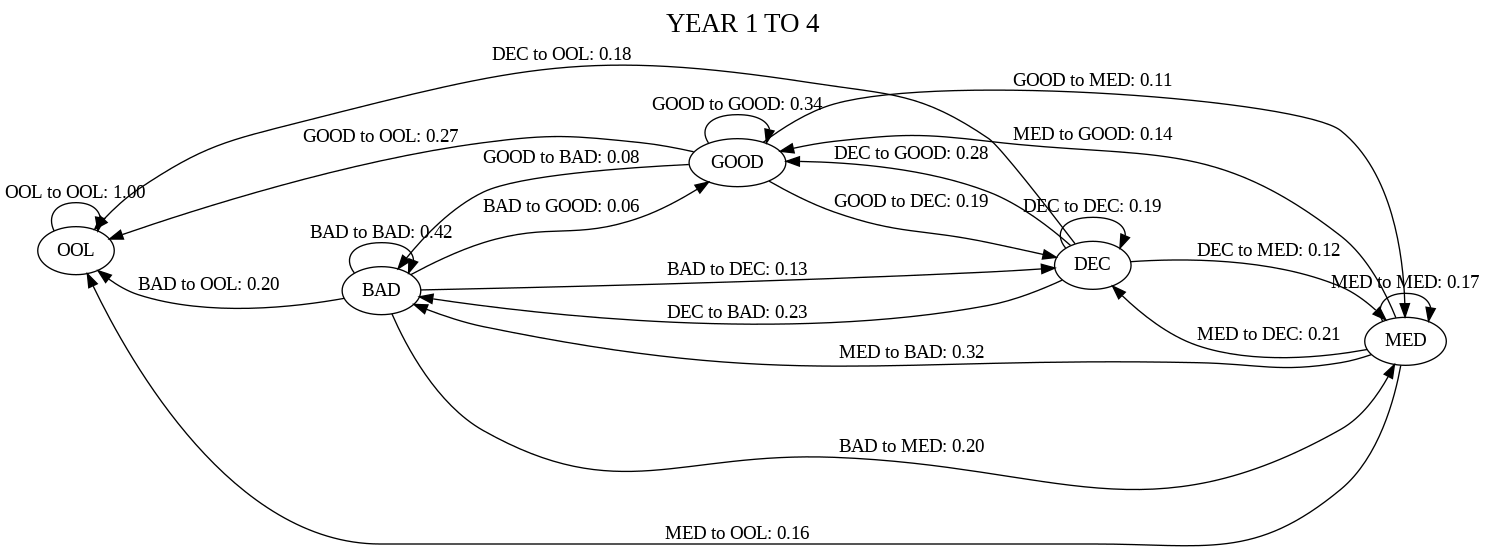

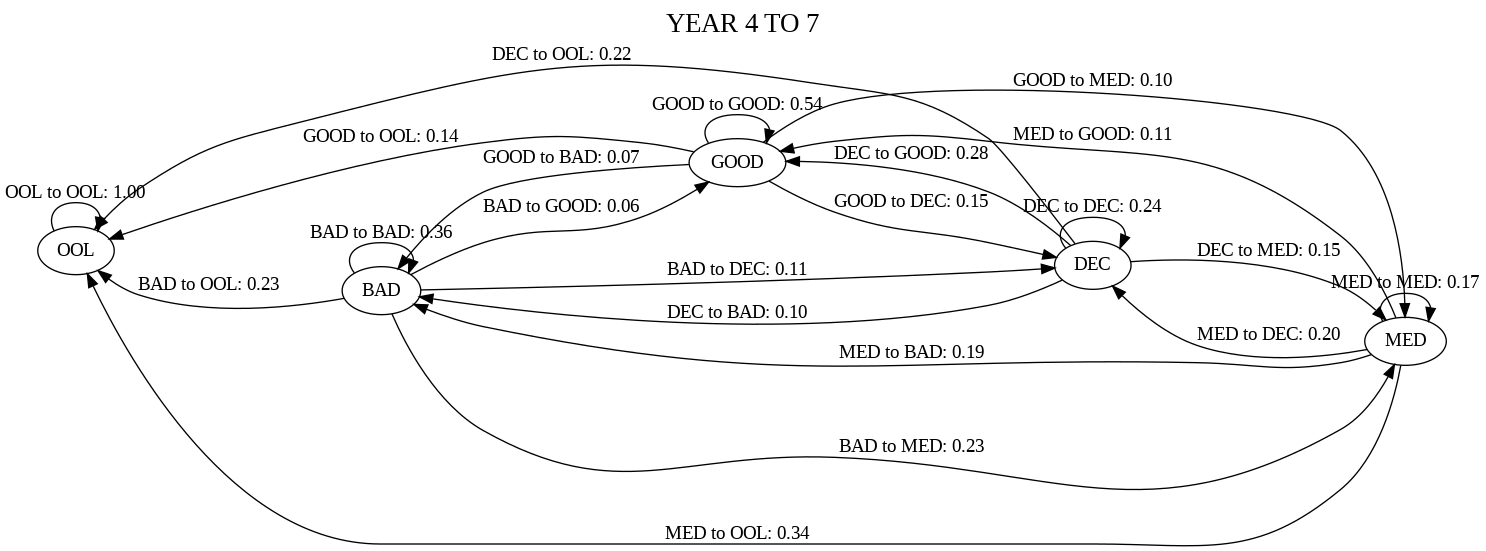

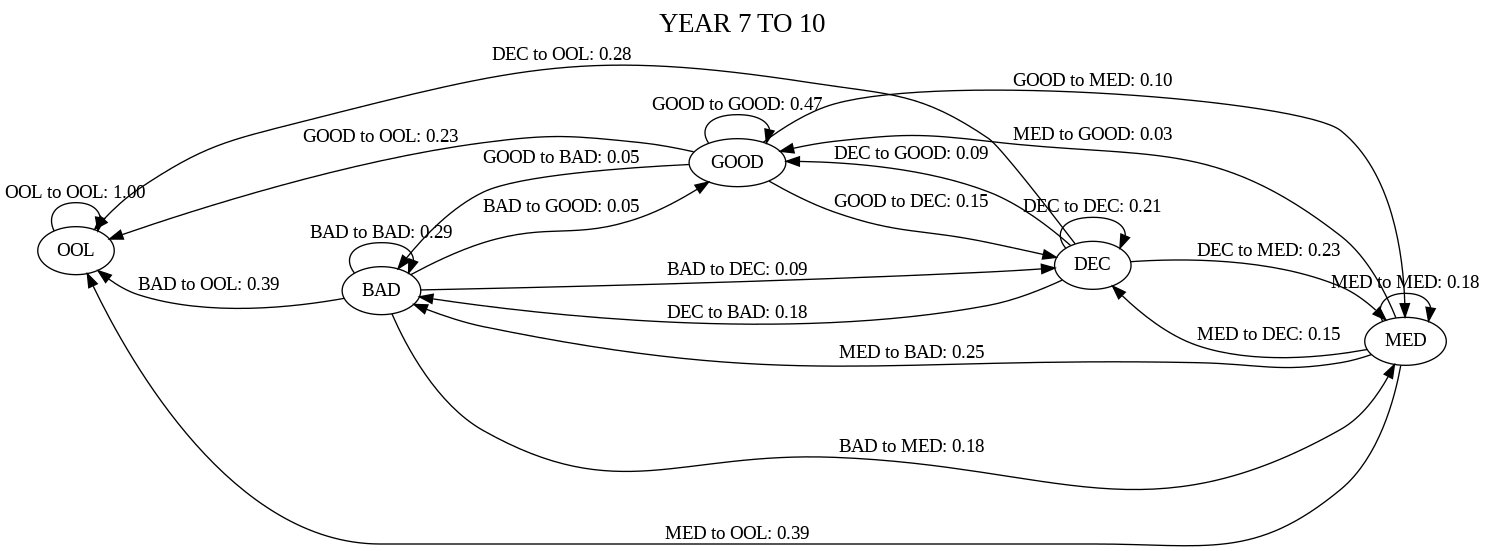

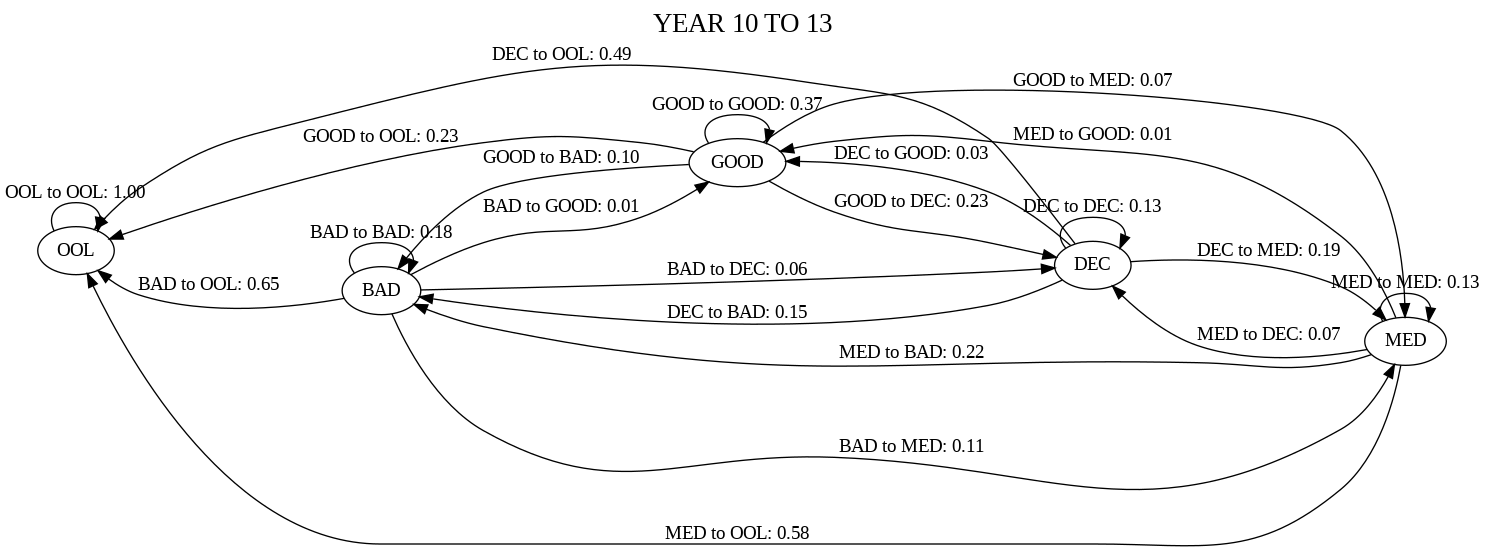

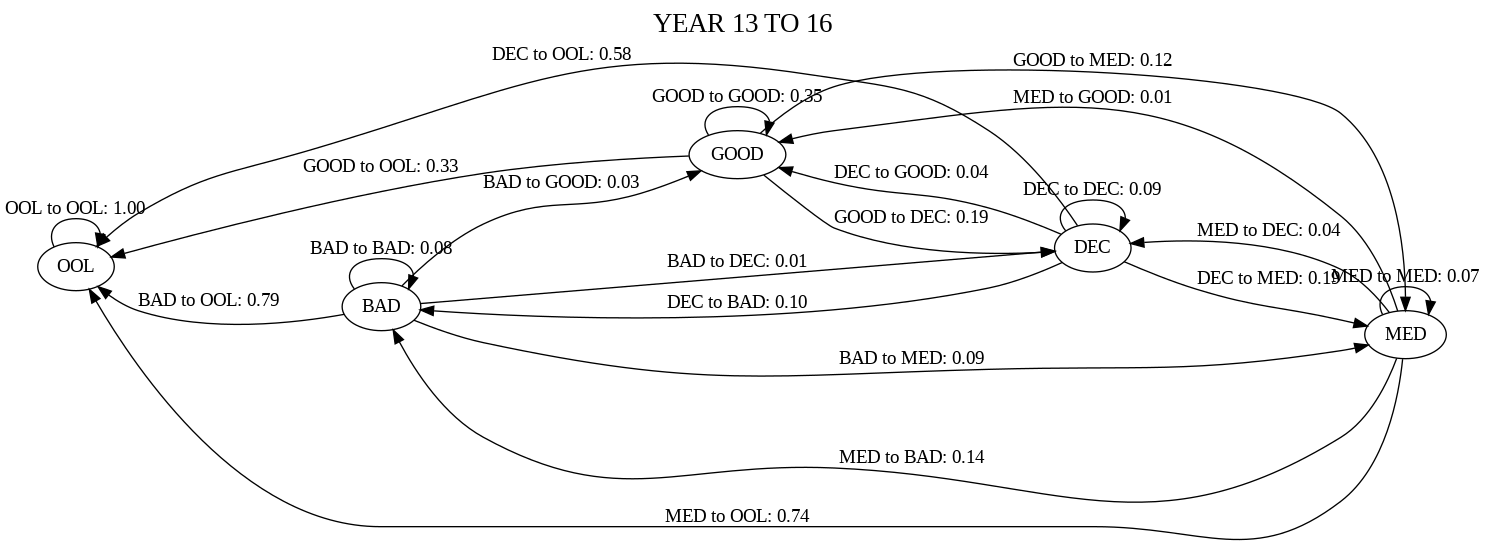

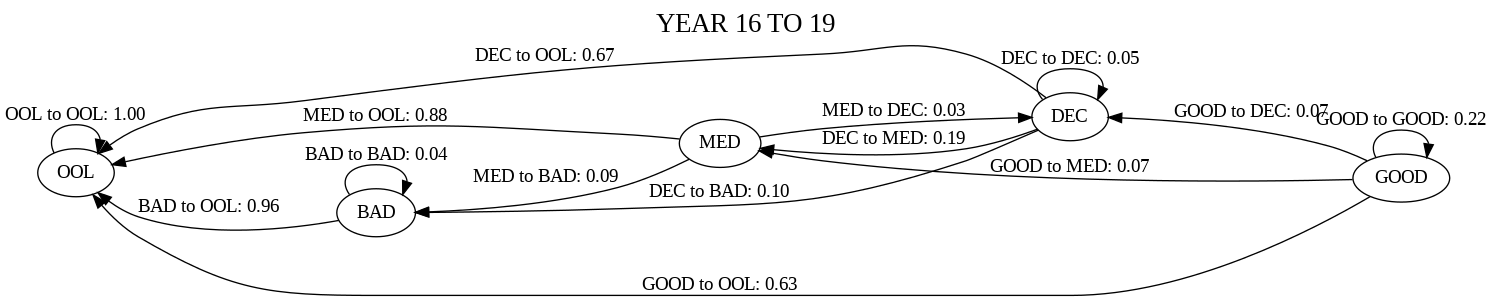

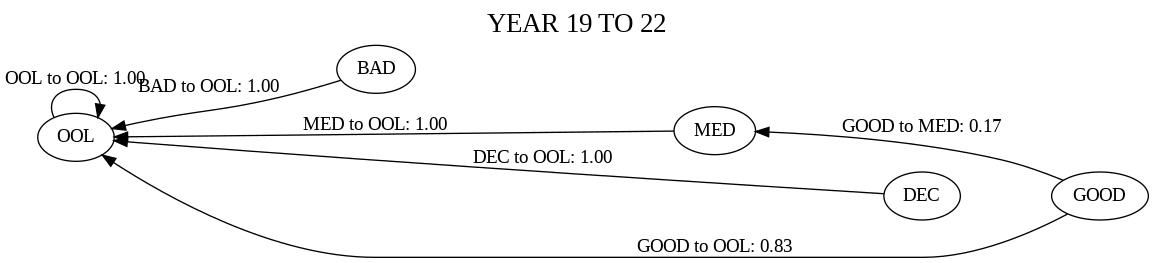

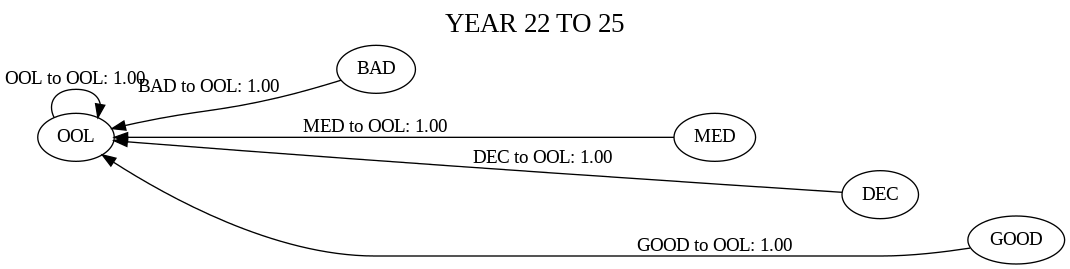

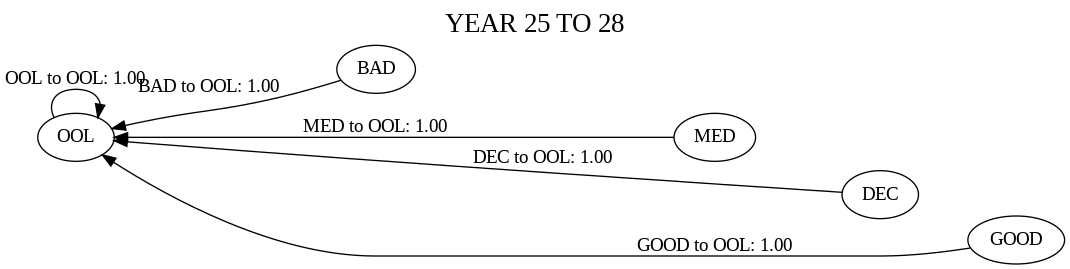

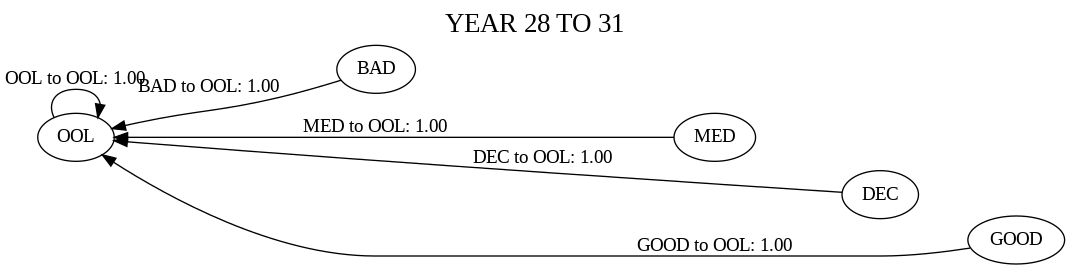

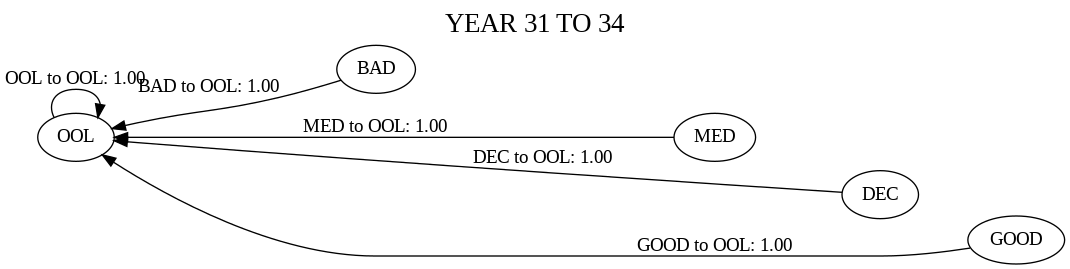

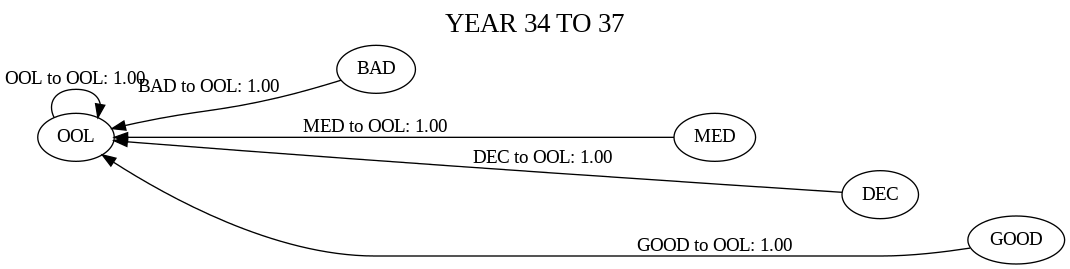

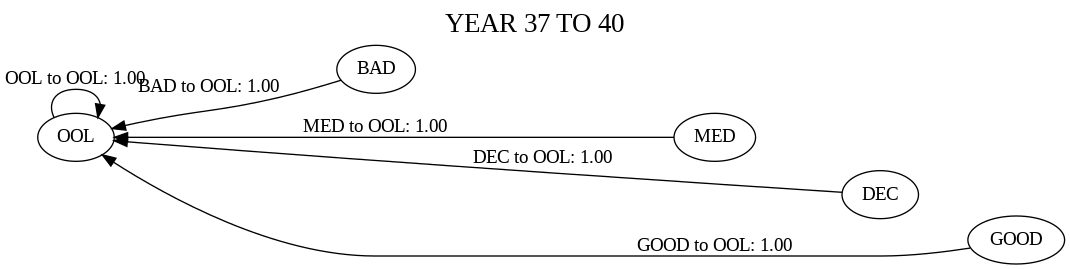

In [ ]:
'''
good = 17.5+
decent = 15 - 17.5
mediocre = 12.5 - 15
bad = 0 - 12.5
ool = -1
'''

from graphviz import Digraph

# Define the states and transitions
states = {0: 'OOL', 1: 'BAD', 2: 'MED', 3: 'DEC', 4: 'GOOD'}

# Convert Numpy matrix to graphviz transition map
def mat_to_graph(matrix):
  map = {}
  for i in range(0, len(matrix)): # Selected state
    for j in range(0, len(matrix)): # For each states
      from_state = states[j]
      to_state = states[i]
      prob = matrix[i, j]
      dir = (from_state, to_state)
      map[dir] = prob
  return map


curr = 0 # Labeling purposes

# Draw state diagram for every transition matrix
for i in range(0, probs.shape[0]):
  # Assign transition_matrix
  transition_matrix = mat_to_graph(probs[i])

  # Create a directed graph
  dot = Digraph()

  # Set the graph layout and title
  dot.attr(rankdir='LR', label=f'YEAR {curr+1} TO {i*time_step+time_step+1}', labelloc='t', fontsize='20')
  curr += time_step

  # Add states
  for state in states.values():
    dot.node(state)

  # Add invisible edges to maintain strict horizontal order
  for j in range(len(states) - 1):
      dot.edge(states[j], states[j + 1], style='invis')

  # Draw arrows
  for (start, end), weight in transition_matrix.items():
    if(weight > 0): # Filter zero-weight
      dot.edge(start, end, label='{} to {}: {:.2f}'.format(start, end, weight))


  # Render the graph
  output_path = 'figure'
  dot.render(output_path, format='png', cleanup=True)

  # Mount drive so it can take the picture
  import os
  from google.colab import drive
  if not os.path.isdir('/content/drive/My Drive'): # Avoid mounting again
    drive.mount('/content/drive')

  # Show picture
  from IPython.display import Image, display
  display(Image(f'{output_path}.png'))
  print()

# *Convergence in Transition Matrix*


Changes: i did M1 x M2 x .. x Mi instead of M2 x M1 in the slides (based on chatgpt so im not sure too)

Subject: **Time-Inhomogenous Markov Chain**


In [ ]:
# Multiply transition matrices and output a transition matrix from 0 to (n * time step)
def cumulative_transition_matrix(n):
  if(n >= probs.shape[0]):
    raise ValueError("n exceeds the number of available years")

  # Calculate cumulative transition matrix
  transition_matrix = probs[0] # init
  absorbing_matrix = np.array([np.full(5, 1), np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5)]) # absorbing matrix

  for i in range(1, n):
    transition_matrix = np.round(transition_matrix @ probs[i], 2) # M1 x M2 x ... Mi

    # # Uncomment to see where the transition matrix is already in steady state (absorbed)
    # if np.array_equal(transition_matrix, absorbing_matrix):
    #   print(f'MATRIX CONVERGES AT YEAR 1 TO {i*time_step+1}, n = {i}')
    #   print(f'YEAR 1 TO {i*time_step+1}')
    #   break

  return transition_matrix

# Example
# n = probs.shape[0]-1
n = 7
print(f'YEAR 1 TO {n*time_step+1}')
print(cumulative_transition_matrix(n))

YEAR 1 TO 22
[[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


# *Initial State Probability*

Just grabbed the probabilty of players allocated to each state initially

In [ ]:
'''
Decided thresholds:
good = 17.5+
decent = 15 - 17.5
mediocre = 12.5 - 15
bad = 0 - 12.5
ool = -1
'''

# Array is sorted in a way: df[i-th iteration, 0-4 (states)]
total_player = timestep_df.shape[0] # Get total player
init_state_prob = np.zeros(5)

# Iterate for all states
for i in range(0, 5):
  players_in_state_i = df[0, i].shape[0] # Taking 0-th iteration for initial state
  init_state_prob[i] = np.round(players_in_state_i / total_player, 3)

# init_state_prob = init_state_prob.reshape(-1, 1)
print(init_state_prob)
print('OOL - BAD - MED - DEC - GOOD')

[0.    0.644 0.207 0.092 0.057]
OOL - BAD - MED - DEC - GOOD


# *State Probability After i-th Year*

Kinda similar to x(n+1) = T^n x(0) we learn.

But since our transition matrix is time dependent, x(n) = T(0->n) x(0). Also based this from chatgpt

In [ ]:
# Using defined function to get the transition matrix from 0 to i-th year and the initial state probability
# We can find the state probability at/after i-th year playing in the league

i = 3 # (i * time_step) year
# x(n) = T(0->n) @ x(0)
state_prob = np.round(cumulative_transition_matrix(i) @ init_state_prob, 3)


print(f'Probability of players ended up at each states on year {i * time_step+1}:')
print(f'OOL:    {state_prob[0]}')
print(f'BAD:    {state_prob[1]}')
print(f'MED:    {state_prob[2]}')
print(f'DEC:    {state_prob[3]}')
print(f'GOOD:   {state_prob[4]}')

Probability of players ended up at each states on year 10:
OOL:    0.618
BAD:    0.13
MED:    0.071
DEC:    0.083
GOOD:   0.089


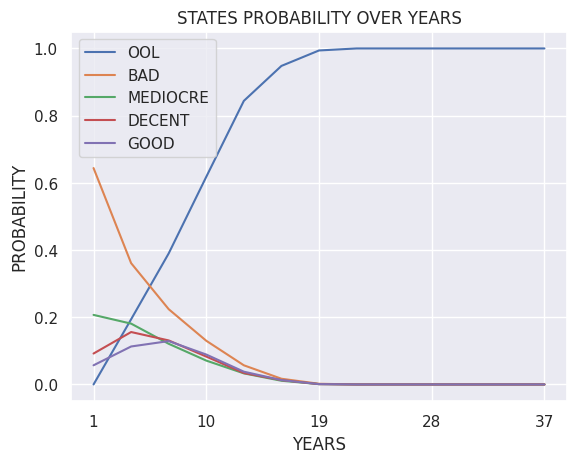

In [ ]:
data_length = probs.shape[0] # Total years available

# Init
states_prob = pd.DataFrame(columns=['TIMESTEP', 'OOL', 'BAD', 'MEDIOCRE', 'DECENT', 'GOOD'])
states_prob.loc[len(states_prob)] = [0, init_state_prob[0], init_state_prob[1], init_state_prob[2], init_state_prob[3], init_state_prob[4]]

for i in range(1, data_length):
  state_prob = np.round(cumulative_transition_matrix(i) @ init_state_prob, 3)
  states_prob.loc[len(states_prob)] = [i, state_prob[0], state_prob[1], state_prob[2], state_prob[3], state_prob[4]]

# Capping the probabilities at 1. Due to rounding, the probability might go a little bit over 1. Doing this doesn't invalidate the results
states_prob['OOL'] = states_prob['OOL'].apply(lambda x: 1 if x > 1 else x)

# Plot for every states
sns.set()

# Define states
states = ['OOL', 'BAD', 'MEDIOCRE', 'DECENT', 'GOOD']

for state in states:
  ax = sns.lineplot(data=states_prob, x='TIMESTEP', y=f'{state}', label=f'{state}')

ax.set_title('STATES PROBABILITY OVER YEARS');
ax.set_ylabel('PROBABILITY');
ax.set_xticks(range(0, data_length, time_step));
ax.set_xticklabels([f'{x*time_step+1}' for x in range(0, data_length, time_step)]);
ax.set_xlabel('YEARS');

# *Simulating Player Growth (Ideal)*

Using the state probability, we are able to simulate the player growth? nonono we have to use the transition matrix 0-3, 3-6 instead of 0-3, 0-6

Use probs[i] and RV from uniform or normal dist? (imma just do it w/ uniform)

Then simulate ideal

Then add stochasticity (injuries, etc)

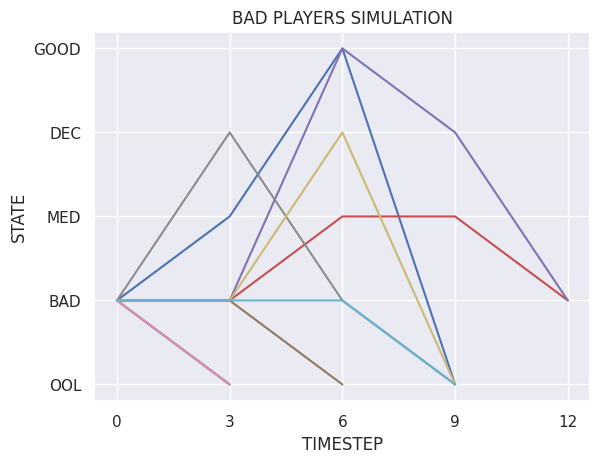

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Initially BAD
# print(probs[0]) # 0-3 yr
# print()
# print(probs[0, :, 1]) # Prob 0-3 yr from BAD state

p = 10 # p players
n = 5 # n year * time step

# Defining states
states = {0: 'OOL', 1: 'BAD', 2: 'MED', 3: 'DEC', 4: 'GOOD'}
starting_state = 1 # Set starting state

# Check that if n is more than the data available
if(n >= probs.shape[0]):
  raise ValueError("n exceeds the number of available years")

# Simulate for k players
for k in range(p):
  sim_data = pd.DataFrame(columns=['TIMESTEP', 'STATE']) # store simulation data
  sim_data.loc[len(sim_data)] = [0, starting_state] # initialize from starting_state (change 1 to k and set p to 5 to see the growth for every initial state over n)

  # Simulate for n time step
  for i in range(1, n):

    state_prob = probs[i, :, starting_state] # Prob 0-3 yr from starting_state (also change 1 to k here)

    rv = uniform.rvs() # Generate random variable from unfirom distribution

    # Get cumulative probability for threshold purposes only
    cumulative_state_prob = np.zeros(5) # init
    cumulative_state_prob[0] = state_prob[0]

    # Loop through every single state
    for j in range(1, len(state_prob)):
      cumulative_state_prob[j] = cumulative_state_prob[j-1] + state_prob[j]

    # cumulative_state_prob[-1] = 1 # Manually set the last probability to 1 b/c the rounding causes the value goes a little bit over 1, i've set the rounding to 3 instead to avoid this
    # print(cumulative_state_prob)

    # Check
    if rv < cumulative_state_prob[0]: # -> OOL
      sim_data.loc[len(sim_data)] = [i, 0]
      break; # Once OOL. Keep them be. Based on assumption
    elif (rv >= cumulative_state_prob[0]) & (rv < cumulative_state_prob[1]): # -> BAD
      sim_data.loc[len(sim_data)] = [i, 1]
    elif (rv >= cumulative_state_prob[1]) & (rv < cumulative_state_prob[2]): # -> MEDIOCRE
      sim_data.loc[len(sim_data)] = [i, 2]
    elif (rv >= cumulative_state_prob[2]) & (rv < cumulative_state_prob[3]): # -> DECENT
      sim_data.loc[len(sim_data)] = [i, 3]
    elif (rv >= cumulative_state_prob[3]) & (rv < cumulative_state_prob[4]): # -> GOOD
      sim_data.loc[len(sim_data)] = [i, 4]

  # Plot
  ax = sns.lineplot(data=sim_data, x='TIMESTEP', y='STATE')

# Display purposes
sns.set()

# Set y ticks settings
ax.set_yticks(range(len(states)));
ax.set_yticklabels(states.values());

# Set x ticks settings
ax.set_xticks(range(0, n));
ax.set_xticklabels(np.array(range(0, n)) * time_step);
ax.set_title(f'{states[starting_state]} PLAYERS SIMULATION');


# *Adding Stochasticity to Players Simulation*